In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

#from fastrenewables.tabular.data import *
#from fastrenewables.tabular.core import *
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *

import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x):
        z = self.gan.noise(x)
        fake_samples = self.gan.generator(None, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, plot_epochs=10, save_model=False):
        # train gan and store parameters and losses in given class
        self.gan.to_device(self.gan.device)
        
        for e in tqdm(range(epochs)):
            
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device)
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                if y.dim() == 3:
                    y = y.flatten(1, 2)[:, 0]
                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

In [4]:
generator = GANMLP([100, 50, 4])
discriminator = GANMLP([4, 50, 1])
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())
model = GAN(generator, discriminator, gen_optim, dis_optim)

data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=2)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)

In [5]:
learner = GANLearner(gan=model)

 97%|█████████▋| 97/100 [00:03<00:00, 29.83it/s]

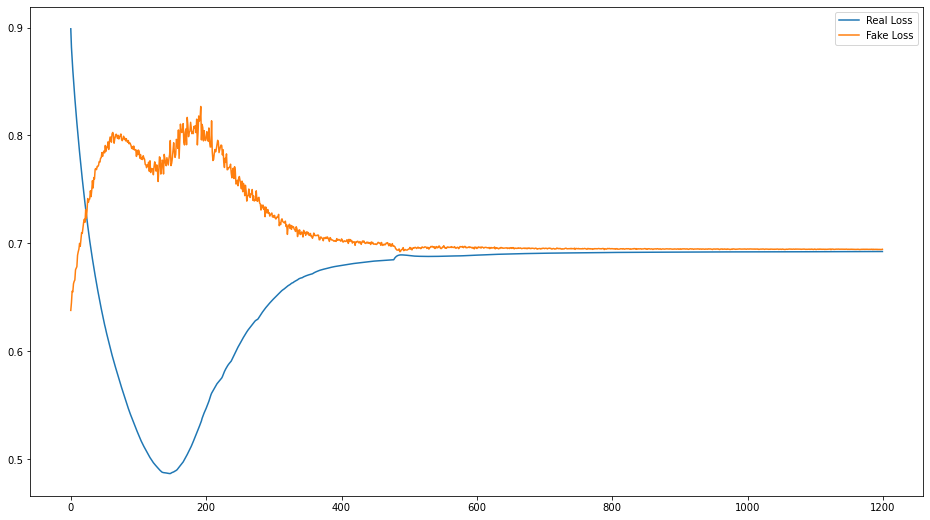

100%|██████████| 100/100 [00:03<00:00, 26.31it/s]


In [6]:
learner.fit(dl, epochs=100, plot_epochs=100)

# Tests:

In [7]:
config = {"model_type" : "cnn",
          "n_noise_samples": 100,
          "act_func_gen": nn.ReLU(),
          "act_func_dis": nn.LeakyReLU(0.2),
          "final_activation_gen": nn.Sigmoid,
          "final_activation_dis": nn.Sigmoid,
          "lr": 1 * 1e-4,
          "epochs": 10000,
          "auxiliary": False
}

In [8]:
#if config['model_type'] == 'mlp':
#    data = DummyDataset()
#    model_fct = GANMLP
#elif config['model_type'] == 'cnn':
#    data = SineDataset()
#    model_fct = GANCNN
#dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    print(x_cat.shape, x_cont.shape, y.shape)
#    break
#
#n_cont_feats = x_cont.shape[1]
#gen_structure = [config['n_noise_samples'], 64, n_cont_feats]
#dis_structure = [n_cont_feats, 64, 1]
#
#generator = model_fct(gen_structure, final_activation=config['final_activation_gen'], cnn_type='cnn' ,transpose=True)
#if config['auxiliary']:
#    n_classes = x_cont.shape[1]
#    input_size = dis_structure[-2]
#    discriminator = model_fct(dis_structure[:-1], final_activation=config['final_activation_dis'], cnn_type='cnn')
#    discriminator = AuxiliaryDiscriminator(discriminator, n_classes, input_size,len_ts=x_cont.shape[-1], model_type=config['model_type'])
#else:
#    discriminator = model_fct(dis_structure, final_activation=config['final_activation_dis'], cnn_type='cnn')
#
#gen_optim = torch.optim.RMSprop(generator.parameters(), lr=config['lr'])
#dis_optim = torch.optim.RMSprop(discriminator.parameters(), lr=config['lr'])
#gan = Gan(generator, discriminator, gen_optim, dis_optim, auxiliary=config['auxiliary'])
#learn = GanLearner(gan)
#
#learn.device = torch.device('cpu')
#learn.fit(dl, epochs=config['epochs'], plot_epochs=config['epochs'])
#
#learn.device = torch.device('cpu')
#
#x_real = x_cont.reshape(1, -1)
#x_fake = learn.generate_samples(x_cont).reshape(1, -1)
#
#plt.figure(figsize=(16, 9))
#plt.hist(x_real, bins=50, label='real', alpha=0.7, density=True)
#plt.hist(x_fake, bins=50, label='fake', alpha=0.7, density=True)
#plt.legend()
#plt.show()

In [9]:
#for i in range(x_cont.shape[1]):
#    plt.figure(figsize=(16, 9))
#    plt.plot(x_cont[0, i, :])
#    plt.plot(learn.generate_samples(x_cont)[0, i, :])
#    plt.show()